In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import trade_data
from passivbot import load_settings
from backtester import *

In [3]:
plt.rcParams['figure.figsize'] = [21, 13]
pd.set_option('precision', 10)

In [4]:
settings = load_settings('default')
settings

{'quot': 'BTC',
 'coins_long': ['ADA',
  'ATOM',
  'BAT',
  'BCH',
  'BNB',
  'DASH',
  'EOS',
  'ETC',
  'ETH',
  'IOST',
  'IOTA',
  'LINK',
  'LTC',
  'MATIC',
  'NEO',
  'ONT',
  'QTUM',
  'RVN',
  'TRX',
  'VET',
  'XLM',
  'XMR',
  'XRP',
  'XTZ',
  'ZEC'],
 'coins_shrt': ['ADA',
  'ATOM',
  'BAT',
  'BCH',
  'DASH',
  'EOS',
  'ETC',
  'ETH',
  'IOST',
  'IOTA',
  'LINK',
  'LTC',
  'MATIC',
  'NEO',
  'ONT',
  'QTUM',
  'RVN',
  'TRX',
  'VET',
  'XLM',
  'XMR',
  'XRP',
  'XTZ',
  'ZEC'],
 'do_not_borrow': ['BNB'],
 'profit_pct': 0.0025,
 'account_equity_pct_per_trade': 0.0006,
 'account_equity_pct_per_hour': 0.0045,
 'hours_rolling_small_trade_window': 1.0,
 'bnb_buffer': 50.3,
 'max_memory_span_days': 60,
 'snapshot_timestamp_millis': 0,
 'ema_spans_minutes': [15, 25, 40, 64, 102, 164, 263, 421, 675, 1080],
 'user': 'default'}

In [32]:
fee = 1 - 0.0675 * 0.01 # vip1


# modify settings here


#settings['profit_pct'] = 0.0025

#settings['account_equity_pct_per_trade'] = 0.0006

settings['account_equity_pct_per_hour'] = 0.0045

settings['max_memory_span_days'] = 40

#settings['ema_spans_minutes'] = [15, 25, 40, 64, 102, 164, 263, 421, 675, 1080]
print(settings['account_equity_pct_per_trade'] * 60)

0.036


In [6]:
symbols = [f'{c}/BTC' for c in settings['coins_long']]
symbols = sorted(symbols)
n_days = 180
symbols

['ADA/BTC',
 'ATOM/BTC',
 'BAT/BTC',
 'BCH/BTC',
 'BNB/BTC',
 'DASH/BTC',
 'EOS/BTC',
 'ETC/BTC',
 'ETH/BTC',
 'IOST/BTC',
 'IOTA/BTC',
 'LINK/BTC',
 'LTC/BTC',
 'MATIC/BTC',
 'NEO/BTC',
 'ONT/BTC',
 'QTUM/BTC',
 'RVN/BTC',
 'TRX/BTC',
 'VET/BTC',
 'XLM/BTC',
 'XMR/BTC',
 'XRP/BTC',
 'XTZ/BTC',
 'ZEC/BTC']

In [7]:
# set no_download to True to load faster if already downloaded ohlcvs
high_low_means = load_hlms(symbols, n_days, no_download=False)

fetched 1m ohlcvs for ADA/BTC 2020-06-29T21:30:00
fetched 1m ohlcvs for ADA/BTC 2020-06-27T14:50:00
fetched 1m ohlcvs for ADA/BTC 2020-04-24T13:50:00
fetched 1m ohlcvs for ADA/BTC 2020-03-03T19:50:00
fetched 1m ohlcvs for ADA/BTC 2020-02-19T01:50:00
fetched 1m ohlcvs for ADA/BTC 2020-02-08T11:20:00
fetched 1m ohlcvs for ADA/BTC 2019-12-31T08:20:00
2020-06-30T14:10:02  2019-12.csv already present, merging... 
2020-06-30T14:10:03  2020-02.csv already present, merging... 
2020-06-30T14:10:04  2020-03.csv already present, merging... 
2020-06-30T14:10:05  2020-04.csv already present, merging... 
2020-06-30T14:10:07  2020-06.csv already present, merging... 
fetched 1m ohlcvs for ATOM/BTC 2020-06-29T21:31:00
fetched 1m ohlcvs for ATOM/BTC 2020-06-27T14:50:00
fetched 1m ohlcvs for ATOM/BTC 2020-04-24T13:50:00
fetched 1m ohlcvs for ATOM/BTC 2020-03-03T19:50:00
fetched 1m ohlcvs for ATOM/BTC 2020-02-19T01:50:00
fetched 1m ohlcvs for ATOM/BTC 2020-02-08T11:20:00
fetched 1m ohlcvs for ATOM/BTC 201

fetched 1m ohlcvs for EOS/BTC 2020-01-04T23:35:00
fetched 1m ohlcvs for EOS/BTC 2020-01-04T06:56:00
fetched 1m ohlcvs for EOS/BTC 2020-01-03T14:17:00
fetched 1m ohlcvs for EOS/BTC 2020-01-02T21:38:00
fetched 1m ohlcvs for EOS/BTC 2020-01-02T04:59:00
2020-06-30T14:12:14  2020-01.csv already present, merging... 
2020-06-30T14:12:15  2020-02.csv already present, merging... 
2020-06-30T14:12:15  2020-03.csv already present, merging... 
2020-06-30T14:12:16  2020-04.csv already present, merging... 
2020-06-30T14:12:17  2020-06.csv already present, merging... 
fetched 1m ohlcvs for ETC/BTC 2020-06-29T21:33:00
fetched 1m ohlcvs for ETC/BTC 2020-06-27T14:50:00
fetched 1m ohlcvs for ETC/BTC 2020-04-24T13:50:00
fetched 1m ohlcvs for ETC/BTC 2020-03-03T19:50:00
fetched 1m ohlcvs for ETC/BTC 2020-02-19T01:50:00
fetched 1m ohlcvs for ETC/BTC 2020-02-08T11:20:00
fetched 1m ohlcvs for ETC/BTC 2020-01-30T15:40:00
fetched 1m ohlcvs for ETC/BTC 2020-01-29T23:01:00
fetched 1m ohlcvs for ETC/BTC 2020-01-29

fetched 1m ohlcvs for IOTA/BTC 2020-01-14T00:04:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-13T07:25:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-12T14:46:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-11T22:07:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-11T05:28:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-10T12:49:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-09T20:10:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-09T03:31:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-08T10:52:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-07T18:13:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-07T01:34:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-06T08:55:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-05T16:16:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-04T23:37:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-04T06:58:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-03T14:19:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-02T21:40:00
fetched 1m ohlcvs for IOTA/BTC 2020-01-02T05:01:00
2020-06-30T14:13:45  2020-01.csv already present, merging... 
2020-06-30T14:13:47 

fetched 1m ohlcvs for NEO/BTC 2020-01-23T00:31:00
fetched 1m ohlcvs for NEO/BTC 2020-01-22T07:52:00
fetched 1m ohlcvs for NEO/BTC 2020-01-21T15:13:00
fetched 1m ohlcvs for NEO/BTC 2020-01-20T22:34:00
fetched 1m ohlcvs for NEO/BTC 2020-01-20T05:55:00
fetched 1m ohlcvs for NEO/BTC 2020-01-19T13:16:00
fetched 1m ohlcvs for NEO/BTC 2020-01-18T20:37:00
fetched 1m ohlcvs for NEO/BTC 2020-01-18T03:58:00
fetched 1m ohlcvs for NEO/BTC 2020-01-17T11:19:00
fetched 1m ohlcvs for NEO/BTC 2020-01-16T18:40:00
fetched 1m ohlcvs for NEO/BTC 2020-01-16T02:01:00
fetched 1m ohlcvs for NEO/BTC 2020-01-15T09:22:00
fetched 1m ohlcvs for NEO/BTC 2020-01-14T16:43:00
fetched 1m ohlcvs for NEO/BTC 2020-01-14T00:04:00
fetched 1m ohlcvs for NEO/BTC 2020-01-13T07:25:00
fetched 1m ohlcvs for NEO/BTC 2020-01-12T14:46:00
fetched 1m ohlcvs for NEO/BTC 2020-01-11T22:07:00
fetched 1m ohlcvs for NEO/BTC 2020-01-11T05:28:00
fetched 1m ohlcvs for NEO/BTC 2020-01-10T12:49:00
fetched 1m ohlcvs for NEO/BTC 2020-01-09T20:10:00


fetched 1m ohlcvs for RVN/BTC 2020-01-22T07:52:00
fetched 1m ohlcvs for RVN/BTC 2020-01-21T15:13:00
fetched 1m ohlcvs for RVN/BTC 2020-01-20T22:34:00
fetched 1m ohlcvs for RVN/BTC 2020-01-20T05:55:00
fetched 1m ohlcvs for RVN/BTC 2020-01-19T13:16:00
fetched 1m ohlcvs for RVN/BTC 2020-01-18T20:37:00
fetched 1m ohlcvs for RVN/BTC 2020-01-18T03:58:00
fetched 1m ohlcvs for RVN/BTC 2020-01-17T11:19:00
fetched 1m ohlcvs for RVN/BTC 2020-01-16T18:40:00
fetched 1m ohlcvs for RVN/BTC 2020-01-16T02:01:00
fetched 1m ohlcvs for RVN/BTC 2020-01-15T09:22:00
fetched 1m ohlcvs for RVN/BTC 2020-01-14T16:43:00
fetched 1m ohlcvs for RVN/BTC 2020-01-14T00:04:00
fetched 1m ohlcvs for RVN/BTC 2020-01-13T07:25:00
fetched 1m ohlcvs for RVN/BTC 2020-01-12T14:46:00
fetched 1m ohlcvs for RVN/BTC 2020-01-11T22:07:00
fetched 1m ohlcvs for RVN/BTC 2020-01-11T05:28:00
fetched 1m ohlcvs for RVN/BTC 2020-01-10T12:49:00
fetched 1m ohlcvs for RVN/BTC 2020-01-09T20:10:00
fetched 1m ohlcvs for RVN/BTC 2020-01-09T03:31:00


fetched 1m ohlcvs for XLM/BTC 2020-01-20T22:34:00
fetched 1m ohlcvs for XLM/BTC 2020-01-20T05:55:00
fetched 1m ohlcvs for XLM/BTC 2020-01-19T13:16:00
fetched 1m ohlcvs for XLM/BTC 2020-01-18T20:37:00
fetched 1m ohlcvs for XLM/BTC 2020-01-18T03:58:00
fetched 1m ohlcvs for XLM/BTC 2020-01-17T11:19:00
fetched 1m ohlcvs for XLM/BTC 2020-01-16T18:40:00
fetched 1m ohlcvs for XLM/BTC 2020-01-16T02:01:00
fetched 1m ohlcvs for XLM/BTC 2020-01-15T09:22:00
fetched 1m ohlcvs for XLM/BTC 2020-01-14T16:43:00
fetched 1m ohlcvs for XLM/BTC 2020-01-14T00:04:00
fetched 1m ohlcvs for XLM/BTC 2020-01-13T07:25:00
fetched 1m ohlcvs for XLM/BTC 2020-01-12T14:46:00
fetched 1m ohlcvs for XLM/BTC 2020-01-11T22:07:00
fetched 1m ohlcvs for XLM/BTC 2020-01-11T05:28:00
fetched 1m ohlcvs for XLM/BTC 2020-01-10T12:49:00
fetched 1m ohlcvs for XLM/BTC 2020-01-09T20:10:00
fetched 1m ohlcvs for XLM/BTC 2020-01-09T03:31:00
fetched 1m ohlcvs for XLM/BTC 2020-01-08T10:52:00
fetched 1m ohlcvs for XLM/BTC 2020-01-07T18:13:00


2020-06-30T14:19:23  2020-02.csv already present, merging... 
2020-06-30T14:19:24  2020-03.csv already present, merging... 
2020-06-30T14:19:25  2020-04.csv already present, merging... 
2020-06-30T14:19:26  2020-06.csv already present, merging... 


In [31]:
df = add_emas(high_low_means, settings['ema_spans_minutes'])
print(f'n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:2f}')

n_days 179.993056


In [ ]:
balance_list, lentr, sentr, lexit, sexit, lexitpl, sexitpl = backtest(df, settings)

84.16% acc equity quot: 2.044740  avg daily gain: 1.004733

In [10]:
# balances are in terms of quot
bldf = pd.DataFrame(balance_list).set_index('timestamp')

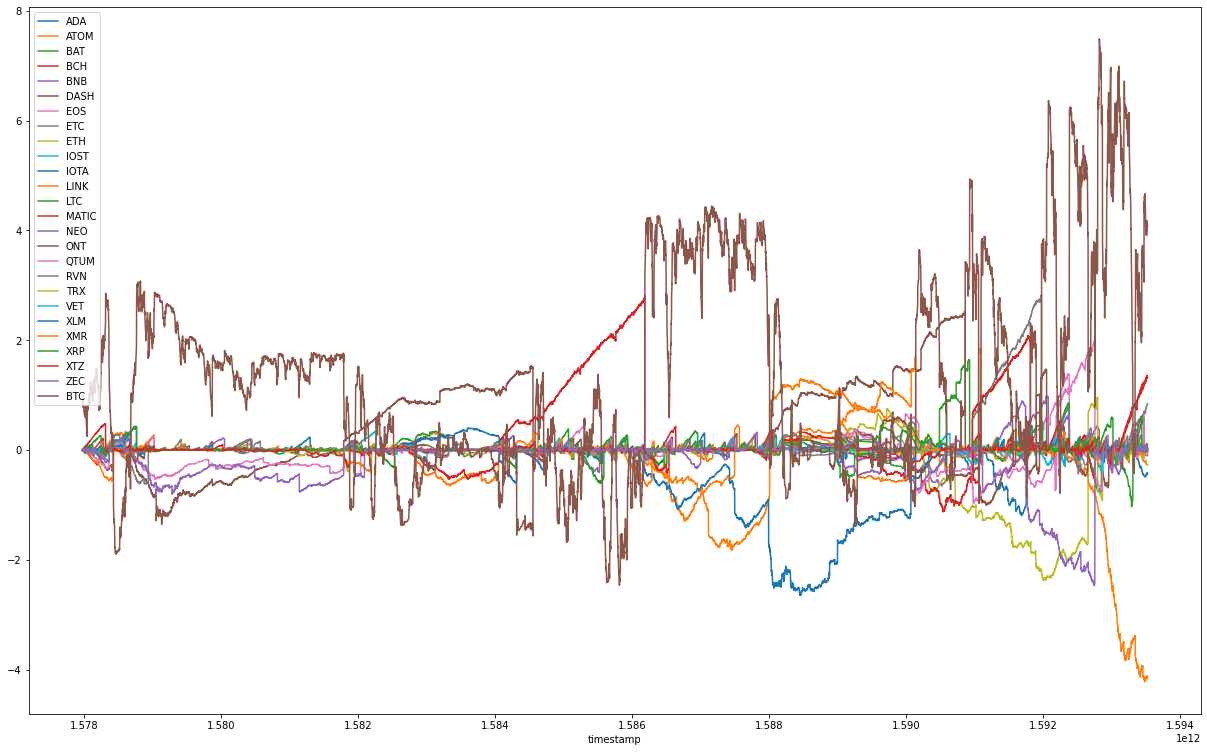

In [12]:
bldf.drop(['acc_equity_quot', 'acc_debt_quot'], axis=1).iloc[::10].plot()

average daily gain 1.00530861


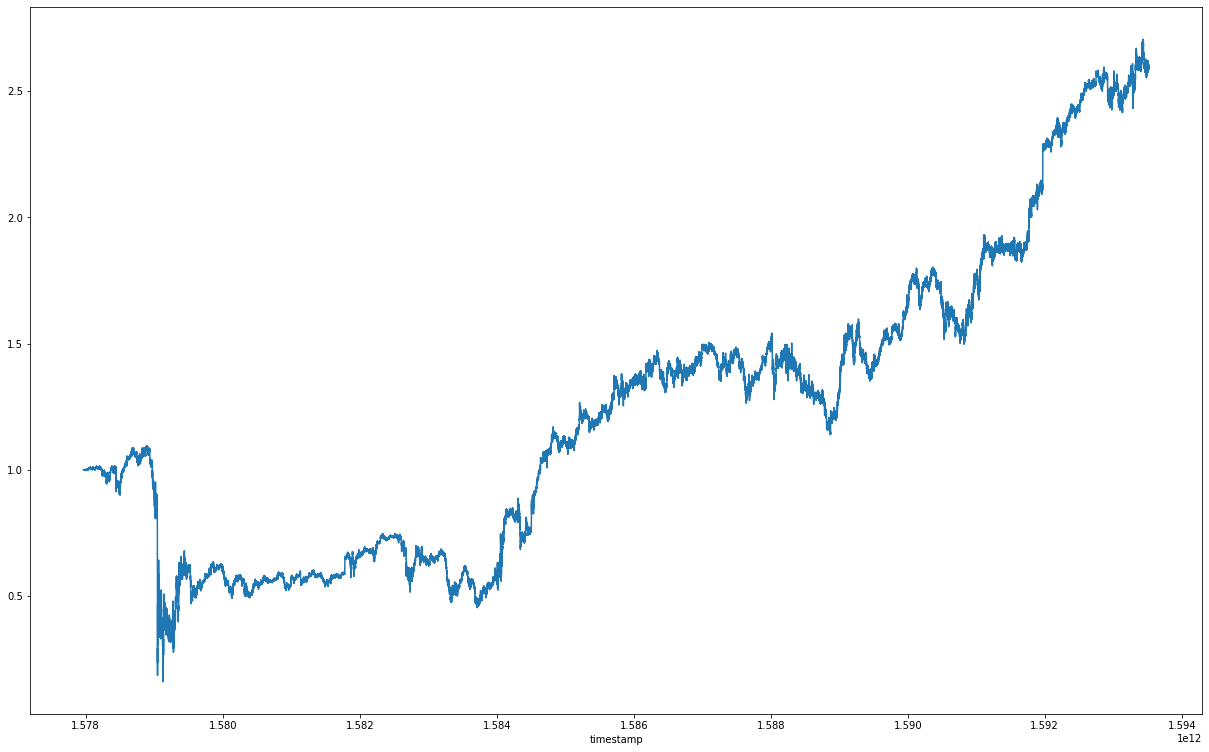

In [13]:
start_equity = bldf.acc_equity_quot.iloc[0]
end_equity = bldf.acc_equity_quot.iloc[-1]
n_days = (bldf.index[-1] - bldf.index[0]) / 1000 / 60 / 60 / 24
avg_daily_gain = (end_equity / start_equity)**(1 / n_days)
print('average daily gain', round(avg_daily_gain, 8))
bldf.acc_equity_quot.plot()

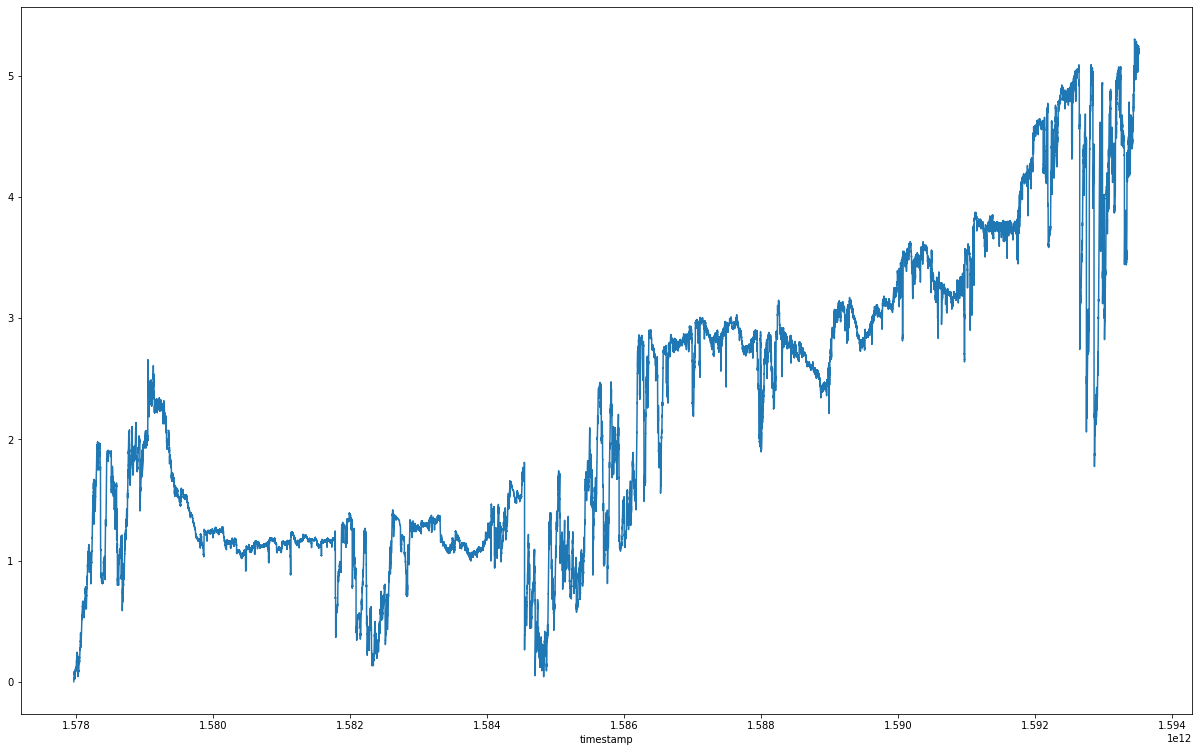

In [14]:
bldf.acc_debt_quot.plot()

In [15]:
sum_vol = 0.0
for s in symbols:
    s_ = s.replace('/', '_')
    vol = sum([e['price'] * e['amount'] for e in lentr[s_]])
    vol += sum([e['price'] * e['amount'] for e in sentr[s_]])
    vol += sum([e['price'] * e['amount'] for e in lexit[s_]])
    vol += sum([e['price'] * e['amount'] for e in sexit[s_]])
    sum_vol += vol
    print(s, vol)
print('approx monthly vol', sum_vol / n_days * 30)

ADA/BTC 48.48512900934652
ATOM/BTC 45.62046375709571
BAT/BTC 45.21129325169849
BCH/BTC 43.28401078141785
BNB/BTC 45.52229752905527
DASH/BTC 45.02058647666997
EOS/BTC 43.741888379025674
ETC/BTC 44.793127950141624
ETH/BTC 44.55937393854641
IOST/BTC 50.50413243015567
IOTA/BTC 41.2104089972551
LINK/BTC 45.34187007196608
LTC/BTC 41.91137542282628
MATIC/BTC 48.904084255082275
NEO/BTC 43.01373587270879
ONT/BTC 44.152841049354876
QTUM/BTC 41.1409807870419
RVN/BTC 50.43149926742562
TRX/BTC 50.31645163085297
VET/BTC 50.49270842673395
XLM/BTC 44.4456739272944
XMR/BTC 42.16326072008822
XRP/BTC 48.21363183323734
XTZ/BTC 43.188146485982955
ZEC/BTC 42.91328445230387
approx monthly vol 189.1043384759555


In [16]:
# bag status at end
sorted([(round(e[1], 6), e[0]) for e in dict(bldf.iloc[-1]).items() if 'acc' not in e[0]])

[(-4.143893, 'LINK'),
 (-0.426578, 'ADA'),
 (-0.268071, 'ATOM'),
 (-0.102073, 'IOTA'),
 (-0.063744, 'ETH'),
 (-0.05379, 'QTUM'),
 (-0.050969, 'TRX'),
 (-0.048518, 'NEO'),
 (-0.019533, 'XLM'),
 (-0.018847, 'BNB'),
 (-0.011741, 'DASH'),
 (-0.004614, 'EOS'),
 (0.0, 'BAT'),
 (0.0, 'RVN'),
 (0.0, 'XMR'),
 (0.000272, 'IOST'),
 (0.001694, 'VET'),
 (0.022698, 'ZEC'),
 (0.025529, 'BCH'),
 (0.038582, 'ONT'),
 (0.039017, 'XRP'),
 (0.099637, 'LTC'),
 (0.846042, 'ETC'),
 (1.308225, 'MATIC'),
 (1.325082, 'XTZ'),
 (4.099007, 'BTC')]

In [23]:
sum_p = 0.0
for s in map(lambda x: x.replace('/', '_'), symbols):
    # all buys
    abdf = pd.DataFrame(sorted(lentr[s] + sexit[s], key=lambda x: x['timestamp'])).set_index('timestamp')

    # all sels
    asdf = pd.DataFrame(sorted(sentr[s] + lexit[s], key=lambda x: x['timestamp'])).set_index('timestamp')
    buy_cost = (abdf.price * abdf.amount).sum()
    sel_cost = (asdf.price * asdf.amount).sum()
    sum_cost = buy_cost + sel_cost
    buy_vwap = buy_cost / abdf.amount.sum()
    sel_vwap = sel_cost / asdf.amount.sum()
    diff = (sel_vwap / buy_vwap) * fee**2
    approx_profit = buy_cost * (diff * fee**2 - 1)
    print(s, f'buy vol: {buy_cost:.4f} sel vol: {sel_cost:.4f} sum vol: {sum_cost:.4f}')
    print(s, f'buy vwap: {buy_vwap:.10f} sel vwap: {sel_vwap:.10f} diff: {(sel_vwap / buy_vwap):.6f}')
    print(s, f'approx profit: {approx_profit:.6f}')
    print()
    sum_p += approx_profit
print('approx sum profit', sum_p)

ADA_BTC buy vol: 23.9546 sel vol: 24.5305 sum vol: 48.4851
ADA_BTC buy vwap: 0.0000059703 sel vwap: 0.0000060471 diff: 1.012864
ADA_BTC approx profit: 0.242721

ATOM_BTC buy vol: 22.6399 sel vol: 22.9806 sum vol: 45.6205
ATOM_BTC buy vwap: 0.0003282981 sel vwap: 0.0003290325 diff: 1.002237
ATOM_BTC approx profit: -0.010553

BAT_BTC buy vol: 22.5389 sel vol: 22.6723 sum vol: 45.2113
BAT_BTC buy vwap: 0.0000238662 sel vwap: 0.0000240237 diff: 1.006598
BAT_BTC approx profit: 0.087524

BCH_BTC buy vol: 21.6217 sel vol: 21.6623 sum vol: 43.2840
BCH_BTC buy vwap: 0.0297405500 sel vwap: 0.0298594229 diff: 1.003997
BCH_BTC approx profit: 0.027869

BNB_BTC buy vol: 22.7174 sel vol: 22.8049 sum vol: 45.5223
BNB_BTC buy vwap: 0.0018877625 sel vwap: 0.0018945633 diff: 1.003603
BNB_BTC approx profit: 0.020346

DASH_BTC buy vol: 22.8153 sel vol: 22.2053 sum vol: 45.0206
DASH_BTC buy vwap: 0.0088953989 sel vwap: 0.0086580836 diff: 0.973322
DASH_BTC approx profit: -0.668575

EOS_BTC buy vol: 21.8780 s

In [24]:
# analyze particular symbol
s = 'XTZ_BTC'

In [25]:
ledf = pd.DataFrame(lentr[s]).set_index('timestamp')
sedf = pd.DataFrame(sentr[s]).set_index('timestamp')
lexitdf = pd.DataFrame(lexit[s]).set_index('timestamp')
sexitdf = pd.DataFrame(sexit[s]).set_index('timestamp')
lexitpdf = pd.DataFrame(lexitpl[s]).set_index('timestamp')
sexitpdf = pd.DataFrame(sexitpl[s]).set_index('timestamp')

In [26]:
# longest bag durations
d = 1000 * 60 * 60 * 24
for e in sorted(np.diff(lexitdf.index / d))[-10:]:
    print('long bag duration days', round(e, 2))
print()
for e in sorted(np.diff(sexitdf.index / d))[-10:]:
    print('shrt bag duration days', round(e, 2))

long bag duration days 1.79
long bag duration days 1.96
long bag duration days 2.19
long bag duration days 2.36
long bag duration days 2.56
long bag duration days 2.71
long bag duration days 2.79
long bag duration days 3.14
long bag duration days 3.9
long bag duration days 25.26

shrt bag duration days 2.19
shrt bag duration days 2.29
shrt bag duration days 2.31
shrt bag duration days 3.05
shrt bag duration days 3.19
shrt bag duration days 3.32
shrt bag duration days 4.6
shrt bag duration days 4.83
shrt bag duration days 8.76
shrt bag duration days 13.8


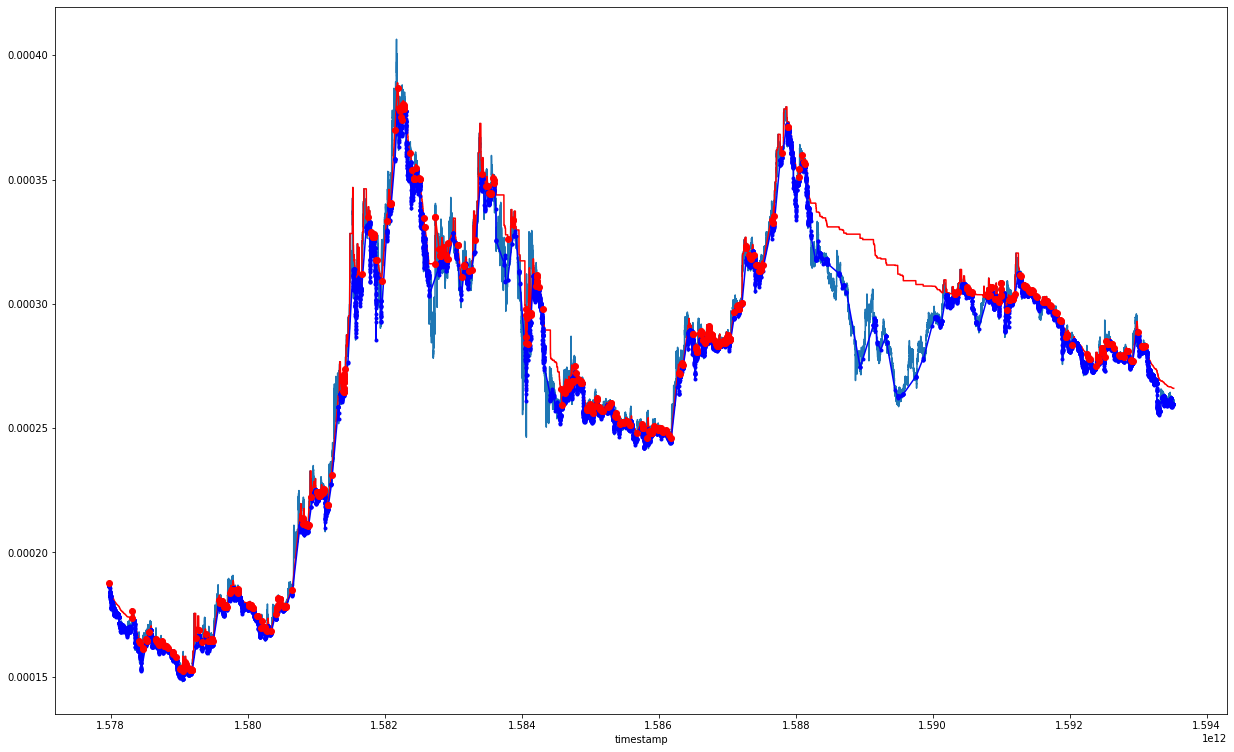

In [27]:
high_low_means[s + '_mean'].plot()
lexitpdf.price.plot(style='r-')
ledf.price.plot(style='b.-')
lexitdf.price.plot(style='ro')

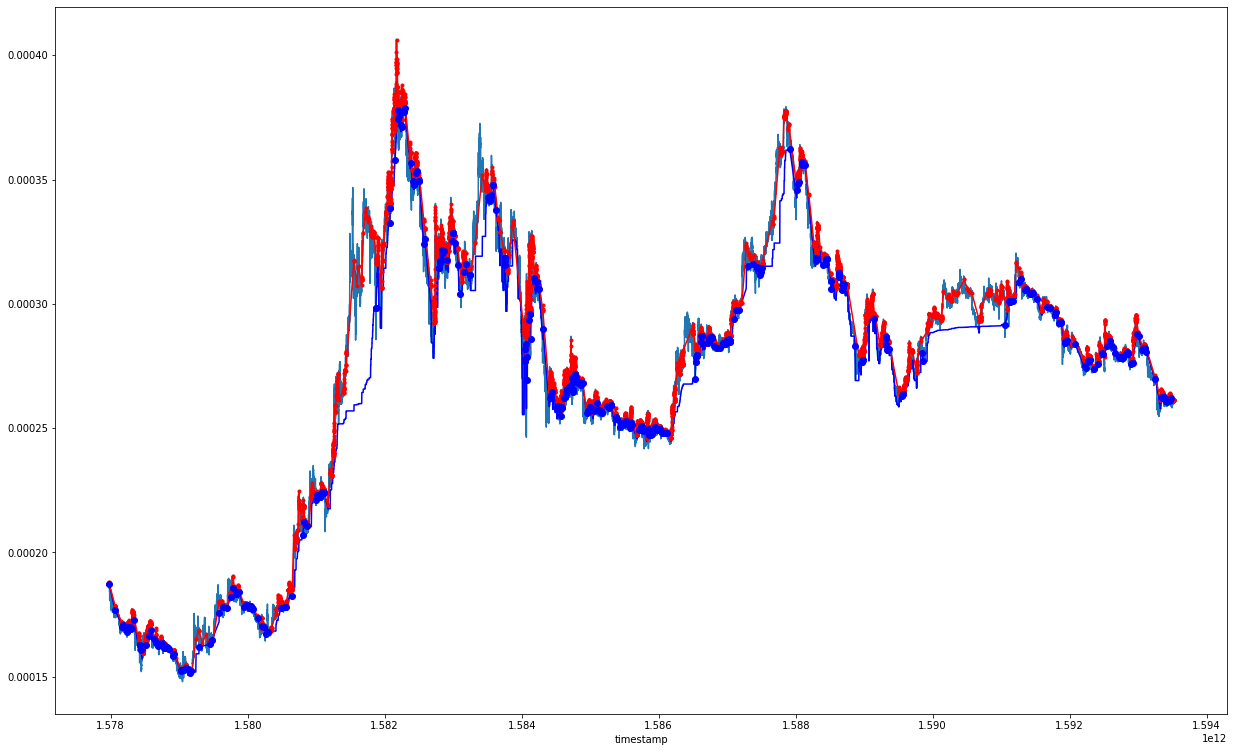

In [28]:
high_low_means[s + '_mean'].plot()
sexitpdf.price.plot(style='b-')
sedf.price.plot(style='r.-')
sexitdf.price.plot(style='bo')